In [12]:
import os
import glob
import argparse
import tempfile
import os
from pathlib import Path
from typing import Tuple, Dict, List

import pandas as pd
import MDAnalysis as mda
import prolif as plf
from rdkit import DataStructs
from rdkit import Chem
from prolif.molecule import Molecule

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Input Preparation

In [13]:
base_dir = '/Users/aoxu/projects/DrugDiscovery/PoseBench'
BASE_DIR = base_dir

In [14]:
df = pd.read_csv(f"{base_dir}/notebooks/posebusters_results_filtered_with_descriptors_predicted_ligands.csv")

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_35511/990605301.py:1: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{base_dir}/notebooks/posebusters_results_filtered_with_descriptors_predicted_ligands.csv")


In [15]:

for col in ["protein_pdb", "predicted_ligand", "true_ligand"]:
    df[col] = df[col].str.replace("/Users/aoxu/projects/DrugDiscovery/PoseBench", BASE_DIR)

In [16]:
assert not df['predicted_ligand'].isnull().any()
df.head()[['protein', 'method', 'true_ligand', 'protein_pdb', 'predicted_ligand']]

,protein,method,true_ligand,protein_pdb,predicted_ligand
0,7ZDY_6MJ,icm,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...
1,7ZDY_6MJ,icm,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...
2,7ZDY_6MJ,icm,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...
3,7ZDY_6MJ,icm,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...
4,7ZDY_6MJ,icm,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...


# Prolif

In [ ]:
protein_path = df[df['protein'] == "8B8H_OJQ"]["protein_pdb"].iloc[0]
ref_ligand_path = df[df['protein'] == "8B8H_OJQ"]["true_ligand"].iloc[0]
pred_pose_path = df[df['protein'] == "8B8H_OJQ"]["predicted_ligand"].iloc[0]
output_dir = None

In [ ]:
rdkit_prot = Chem.MolFromPDBFile(protein_path, removeHs=False)
protein = plf.Molecule(rdkit_prot)

supplier = Chem.SDMolSupplier(pred_pose_path)
ligands = [Molecule.from_rdkit(mol) for mol in supplier if mol is not None]
ligand = ligands[0]  # Take the first ligand (if multiple poses exist)

In [ ]:
pose_iterable = plf.sdf_supplier(pred_pose_path)
# Initialize a fingerprint calculator
fp = plf.Fingerprint(plf.Fingerprint.list_available())

# Compute interactions
fp.run_from_iterable(pose_iterable, protein)
docked_fp = fp.ifp[0]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fp.to_pickle("fingerprint.pkl")
fp = plf.Fingerprint.from_pickle("fingerprint.pkl")
fp

<prolif.fingerprint.Fingerprint: 15 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'XBAcceptor', 'XBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'FaceToFace', 'EdgeToFace', 'PiStacking', 'MetalDonor', 'MetalAcceptor', 'VdWContact'] at 0x33a2bdca0>

In [ ]:
pose_index = 0
ligand_residue = "UNL1"
protein_residue = "TYR273.B"

fp.ifp[0][(ligand_residue, protein_residue)]

{'Hydrophobic': ({'indices': {'ligand': (0,), 'protein': (5,)},
   'parent_indices': {'ligand': (0,), 'protein': (9077,)},
   'distance': 3.968599439897484},),
 'FaceToFace': ({'indices': {'ligand': (0, 1, 2, 3, 15, 4),
    'protein': (5, 6, 8, 10, 9, 7)},
   'parent_indices': {'ligand': (0, 1, 2, 3, 15, 4),
    'protein': (9077, 9078, 9080, 9082, 9081, 9079)},
   'distance': 3.843863654642627,
   'plane_angle': 166.5807350464617,
   'normal_to_centroid_angle': 5.00438214073472},),
 'PiStacking': ({'indices': {'ligand': (0, 1, 2, 3, 15, 4),
    'protein': (5, 6, 8, 10, 9, 7)},
   'parent_indices': {'ligand': (0, 1, 2, 3, 15, 4),
    'protein': (9077, 9078, 9080, 9082, 9081, 9079)},
   'distance': 3.843863654642627,
   'plane_angle': 166.5807350464617,
   'normal_to_centroid_angle': 5.00438214073472},),
 'VdWContact': ({'indices': {'ligand': (6,), 'protein': (7,)},
   'parent_indices': {'ligand': (6,), 'protein': (9079,)},
   'distance': 3.323107019547996},)}

In [ ]:
prolig_df = fp.to_dataframe(index_col="Pose")
prolig_df

ligand             UNL1                                                       \
protein        HIS174.A              VAL176.A ASP179.A              ASN214.A   
interaction Hydrophobic VdWContact VdWContact  HBDonor VdWContact VdWContact   
Pose                                                                           
0                  True       True       True     True       True       True   

ligand                                                   ...             \
protein        ILE364.A    TYR366.A                      ...   TYR273.B   
interaction Hydrophobic Hydrophobic CationPi VdWContact  ... VdWContact   
Pose                                                     ...              
0                  True        True     True       True  ...       True   

ligand                                                                        \
protein        TYR292.B                         ARG298.B            ILE319.B   
interaction Hydrophobic HBAcceptor VdWContact HBAcceptor VdWContact  HBDonor   
Pose                                                                           
0                  True       True       True       True       True     True   

ligand                                        
protein                  MET321.B             
interaction VdWContact HBAcceptor VdWContact  
Pose                                          
0                 True       True       True  

[1 rows x 23 columns]

In [ ]:
# load the reference
supplier = Chem.SDMolSupplier(ref_ligand_path)
ligands = [Molecule.from_rdkit(mol) for mol in supplier if mol is not None]
ref_mol = ligands[0]  # Take the first ligand (if multiple poses exist)

# generate IFP for the reference
fp_ref = plf.Fingerprint(fp.interactions)
fp_ref.run_from_iterable([ref_mol], protein)
ref_fp = fp_ref.ifp[0]
df_ref = fp_ref.to_dataframe(index_col="Pose")

# set the "pose index" to -1
df_ref.rename(index={0: -1}, inplace=True)
# set the ligand name to be the same as poses
# df_ref.rename(columns={str(ref_mol[0].resid): df.columns.levels[0][0]}, inplace=True)
df_ref

  0%|          | 0/1 [00:00<?, ?it/s]

ligand             UNL1                                                \
protein         VAL42.A    TYR48.A                TRP90.A    HIS174.A   
interaction Hydrophobic HBAcceptor VdWContact Hydrophobic Hydrophobic   
Pose                                                                    
-1                 True       True       True        True        True   

ligand                                                            ...  \
protein                                                 SER215.A  ...   
interaction PiCation FaceToFace PiStacking VdWContact HBAcceptor  ...   
Pose                                                              ...   
-1              True       True       True       True       True  ...   

ligand                                                                \
protein       ILE233.A    TYR366.A                          TYR273.B   
interaction VdWContact Hydrophobic HBAcceptor VdWContact Hydrophobic   
Pose                                                                   
-1                True        True       True       True        True   

ligand                                                                
protein                   CYS320.B    MET321.B                        
interaction VdWContact Hydrophobic Hydrophobic HBAcceptor VdWContact  
Pose                                                                  
-1                True        True        True       True       True  

[1 rows x 27 columns]

In [ ]:
prolig_df.xs("PiStacking", level="interaction", axis=1)

ligand,UNL1
protein,TYR273.B
Pose,
0,True


In [ ]:
df_ref.xs("PiStacking", level="interaction", axis=1).head(5)

ligand,UNL1
protein,HIS174.A
Pose,
-1,True


In [ ]:
df_ref.to_csv("ref_fp.csv")

## Compare

### Tanimoto distance

In [ ]:
bitvectors = plf.to_bitvectors(df_ref_poses)
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors[1:])
tanimoto_sims

[0.19047619047619047]

### set comparisons

In [ ]:
# Assume fp_docked and fp_reference are dictionary-like
docked_interactions = set(docked_fp.keys())
reference_interactions = set(ref_fp.keys())

common = docked_interactions.intersection(reference_interactions)
unique_docked = docked_interactions.difference(reference_interactions)
unique_reference = reference_interactions.difference(docked_interactions)

print("Common interactions:", common)
print("Unique to docked ligand:", unique_docked)
print("Unique to reference ligand:", unique_reference)

In [ ]:
# Create a pandas Series from each dictionary
series_docked = pd.Series(docked_fp, name="Docked")
series_ref = pd.Series(ref_fp, name="Reference")

# Combine into one DataFrame. Missing values are filled with 0.
df = pd.concat([series_docked, series_ref], axis=1).fillna(0)
df_numeric = df.astype(int)

# Plot a bar chart to compare interaction scores
df_numeric.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Interaction score/count")
plt.title("Comparison of Docked vs Reference Interactions")
plt.show()

## Visualizations

<Axes: xlabel='Pose'>

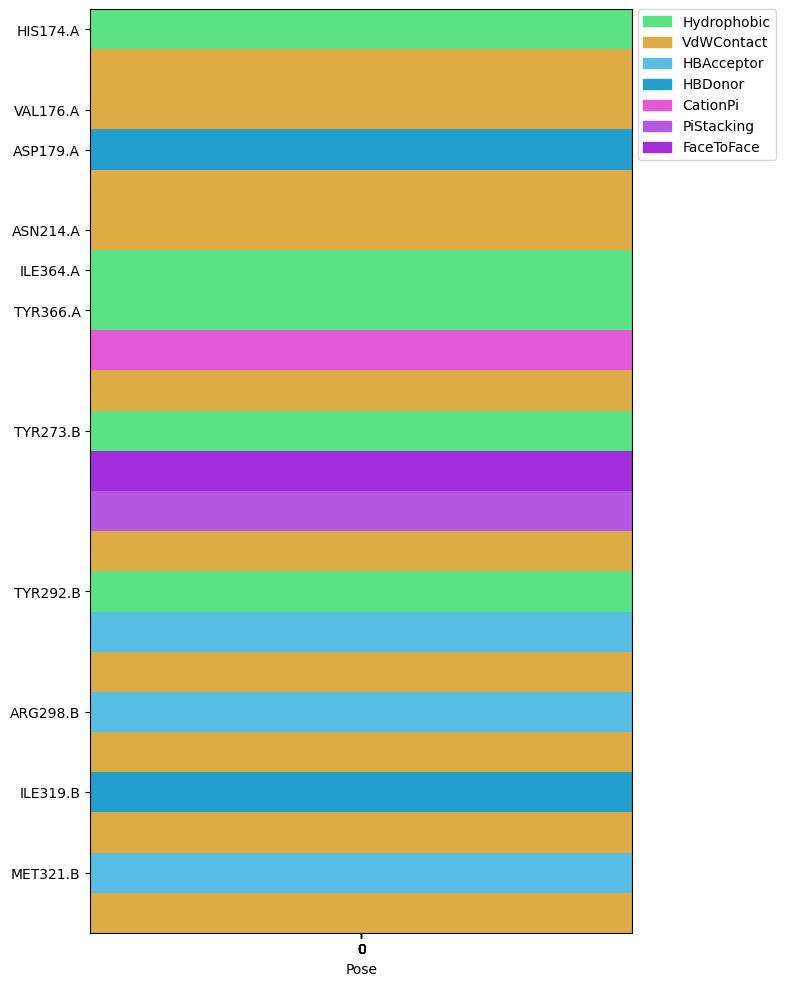

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fp.plot_barcode(xlabel="Pose")

In [ ]:
view = fp.plot_lignetwork(pose_iterable[0])
view

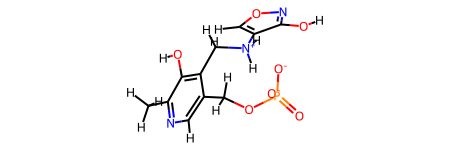

In [ ]:
pose_iterable[0]

In [ ]:
from prolif.plotting.complex3d import Complex3D

pose_index = 0
comp3D = Complex3D.from_fingerprint(
    fp, pose_iterable[pose_index], protein, frame=pose_index
)

pose_index = 0
other_comp3D = Complex3D.from_fingerprint(
    fp, pose_iterable[pose_index], protein, frame=pose_index
)

view = comp3D.compare(other_comp3D)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
ifp = fp.generate(protein, ligand)
ifp

{(ResidueId(HIS, 174, A), ResidueId(UNL, 1, None)): array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]), (ResidueId(ASN, 214, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(ILE, 364, A), ResidueId(UNL, 1, None)): array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]), (ResidueId(TYR, 366, A), ResidueId(UNL, 1, None)): array([ True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True]), (ResidueId(TYR, 273, B), ResidueId(UNL, 1, None)): array([ True, False, False, False, False, False, False, False, False,
        True, False,  True, False, False,  True]), (ResidueId(TYR, 292, B), ResidueId(UNL, 1, None)): array([ True, False,  True, False, False, False, False, False, False,
       False, Fals

In [ ]:
supplier = Chem.SDMolSupplier(ref_ligand_path)
ref_ligands = [Molecule.from_rdkit(mol) for mol in supplier if mol is not None]
ref_ligand = ligands[0]  # Take the first ligand (if multiple poses exist)
ifp = fp.generate(protein, ligand)
ifp

{(ResidueId(HIS, 174, A), ResidueId(UNL, 1, None)): array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]), (ResidueId(ASN, 214, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(ILE, 364, A), ResidueId(UNL, 1, None)): array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]), (ResidueId(TYR, 366, A), ResidueId(UNL, 1, None)): array([ True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True]), (ResidueId(TYR, 273, B), ResidueId(UNL, 1, None)): array([ True, False, False, False, False, False, False, False, False,
        True, False,  True, False, False,  True]), (ResidueId(TYR, 292, B), ResidueId(UNL, 1, None)): array([ True, False,  True, False, False, False, False, False, False,
       False, Fals

# Batch Analysis

### Basic Analysis

### Detailed Analysis with interaction type

In [17]:
def compute_reference_fingerprint(ref_ligand_path: str, protein_path: str) -> pd.DataFrame:
    """
    Generates a ProLIF fingerprint for a single reference pose.
    Returns a DataFrame with a single row (Pose = 'reference').
    """
    fp_calc = plf.Fingerprint()

    # Load the reference ligand
    # ref_mol = Chem.SDMolSupplier(ref_ligand_path)[0]
    # ref_mol.SetProp("_Name", "reference")  # label the pose

    supplier = Chem.SDMolSupplier(ref_ligand_path)
    ligands = [Molecule.from_rdkit(mol) for mol in supplier if mol is not None]
    ref_mol = ligands[0]  # Take the first ligand (if multiple poses exist)
    ref_mol.SetProp("_Name", "reference")  # label the pose

    # Load the protein
    rdkit_prot = Chem.MolFromPDBFile(protein_path, removeHs=False)
    protein = plf.Molecule(rdkit_prot)

    # Run ProLIF
    fp_calc.run_from_iterable([ref_mol], protein)

    # Convert to DataFrame
    ref_fp_df = fp_calc.to_dataframe(index_col="Pose")
    return ref_fp_df

In [18]:
from rdkit.Chem import rdMolTransforms
from typing import Tuple

class ConformationAnalyzer:
    """
    Analyzes protein-ligand interactions for multiple conformations using ProLIF.
    This class handles loading structures and generating interaction fingerprints
    for multiple poses of the same protein-ligand system.
    """
    def __init__(self, df: pd.DataFrame):
        """
        Initialize with a DataFrame containing paths to structures.

        Parameters:
            df: DataFrame with columns for predicted_ligand, protein_pdb, method, and rank
        """
        self.df = df
        self.fp_calculator = plf.Fingerprint()
        self.results = {}  # Stores method -> fingerprint DataFrame

    def combine_conformations(self, method_name: str) -> Tuple[str, str]:
        """
        Combines multiple conformations into a single SDF file for a given method.
        Returns the combined ligand SDF path and protein PDB path.
        """
        method_data = self.df[self.df['method'] == method_name].sort_values('rank')

        temp_sdf = tempfile.NamedTemporaryFile(suffix='.sdf', delete=False)
        writer = Chem.SDWriter(temp_sdf.name)

        for _, row in method_data.iterrows():
            mol = Chem.SDMolSupplier(str(row['predicted_ligand']))[0]
            if mol is not None:
                mol.SetProp('_Name', f"Pose_{row['rank']}")
                writer.write(mol)
        writer.close()

        protein_path = str(method_data.iloc[0]['protein_pdb'])
        return temp_sdf.name, protein_path

    def analyze_method(self, method_name: str) -> pd.DataFrame:
        """
        Analyzes protein-ligand interactions for all conformations of a method
        and returns a ProLIF fingerprint DataFrame.
        """
        try:
            ligand_file, protein_path = self.combine_conformations(method_name)

            ligands = plf.sdf_supplier(ligand_file)
            rdkit_prot = Chem.MolFromPDBFile(protein_path, removeHs=False)
            protein = plf.Molecule(rdkit_prot)

            self.fp_calculator.run_from_iterable(ligands, protein)
            fp_df = self.fp_calculator.to_dataframe(index_col="Pose")
            self.results[method_name] = fp_df

            # Cleanup temp file
            os.unlink(ligand_file)

            return fp_df
        except Exception as e:
            print(f"Error analyzing method {method_name}: {str(e)}")
            if 'ligand_file' in locals():
                os.unlink(ligand_file)
            raise

    def analyze_all_methods(self) -> dict:
        """
        Runs analyze_method() for all unique methods in self.df.
        Returns a dict of {method: fingerprint_df}.
        """
        methods = self.df['method'].unique()
        for method in methods:
            self.analyze_method(method)
        return self.results

    def summarize_interactions(self, method_name: str) -> pd.DataFrame:
        """
        Summarizes how often each interaction appears across all poses of a method.
        """
        if method_name not in self.results:
            self.analyze_method(method_name)
        fp_df = self.results[method_name]

        summary = pd.DataFrame({
            'occurrence_rate': fp_df.mean(),
            'always_present': fp_df.all(),
            'never_present': ~fp_df.any(),
            'variable': fp_df.any() & ~fp_df.all()
        })
        return summary

    def compare_with_reference(self, method_name: str, ref_fp_df: pd.DataFrame) -> pd.DataFrame:
        """
        Compare the fingerprint of each pose (for the given method) to a single-row
        reference fingerprint (e.g., a crystal pose).

        Returns a summary DataFrame that shows, for each pose:
            - number of 'missing' interactions (in ref but not in pose)
            - number of 'extra' interactions (in pose but not in ref)
            - number of 'common' interactions (in both ref and pose)
            - total interactions in reference
            - total interactions in pose
        """
        # Ensure we have the method fingerprint
        if method_name not in self.results:
            self.analyze_method(method_name)
        method_fp = self.results[method_name]

        ref_index = ref_fp_df.index[0]
        ref_fp = ref_fp_df.loc[ref_index]  # This is a Series with the same multi-index columns
        
        # Prepare a list to hold comparison stats
        comparison_rows = []

        for pose_label, row in method_fp.iterrows():
            missing_mask = ref_fp & ~row
            extra_mask = ~ref_fp & row
            common_mask = ref_fp & row

            comparison_info = {
                'pose': pose_label,
                'num_missing': missing_mask.sum(),
                'num_extra': extra_mask.sum(),
                'num_common': common_mask.sum(),
                'total_in_ref': ref_fp.sum(),
                'total_in_pose': row.sum(),
            }
            comparison_rows.append(comparison_info)

        comparison_df = pd.DataFrame(comparison_rows)
        return comparison_df

    def compare_with_reference_detailed(self, method_name: str, ref_fp_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Compare the interaction fingerprint of each pose (for a given method)
        to a single-row reference fingerprint (e.g., a crystal pose),
        returning two DataFrames that show how many interactions of each type
        are 'missing' or 'extra' for each pose.

        Returns:
            missing_df: A DataFrame indexed by pose label, with columns for each
                        interaction type, containing how many times that interaction
                        is missing compared to the reference.
            extra_df:   Same structure, showing how many times that interaction
                        is extra in the pose (i.e., not present in the reference).
        """
        if method_name not in self.results:
            self.analyze_method(method_name)
        method_fp = self.results[method_name]

        ref_index = ref_fp_df.index[0]
        ref_fp = ref_fp_df.loc[ref_index]

        # Gather all interaction types from the multi-index columns
        interaction_types = method_fp.columns.get_level_values("interaction").unique()

        missing_df = pd.DataFrame(0, index=method_fp.index, columns=interaction_types)
        extra_df = pd.DataFrame(0, index=method_fp.index, columns=interaction_types)
    
        for pose_label, pose_fp in method_fp.iterrows():
            missing_mask = ref_fp & ~pose_fp  # true in reference, false in pose
            extra_mask   = ~ref_fp & pose_fp  # false in reference, true in pose

            missing_counts = missing_mask.astype(int).groupby(level="interaction").sum()
            extra_counts   = extra_mask.astype(int).groupby(level="interaction").sum()

            for i_type, i_count in missing_counts.items():
                missing_df.at[pose_label, i_type] = i_count
            for i_type, i_count in extra_counts.items():
                extra_df.at[pose_label, i_type] = i_count

        return missing_df, extra_df


In [ ]:
# 1. Prepare your input DataFrame (with predicted_ligand, protein_pdb, method, rank columns)
# input_df = pd.DataFrame({
#     'predicted_ligand': [...],
#     'protein_pdb': [...],
#     'method': [...],
#     'rank': [...],
#     # etc.
# })

protein = "8B8H_OJQ"
input_df = df[df['protein'] == protein]

# 2. Compute the reference fingerprint
reference_ligand_path = input_df['true_ligand'].iloc[0]
protein_path = input_df['protein_pdb'].iloc[0]
# print(reference_ligand_path, protein_path)
ref_fp_df = compute_reference_fingerprint(reference_ligand_path, protein_path)
# -> ref_fp_df has 1 row, multi-index columns

# 3. Analyze your method(s)
analyzer = ConformationAnalyzer(input_df)
method_fp_df = analyzer.analyze_method("icm")

# 4. Compare with the reference
comparison_df = analyzer.compare_with_reference("icm", ref_fp_df)

print("Comparison with reference pose:")
print(comparison_df)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Comparison with reference pose:
   pose  num_missing  num_extra  num_common  total_in_ref  total_in_pose
0     0           10          0           7            26             17
1     1            3          0          14            26             26
2     2            9          0           8            26             24
3     3            4          0          13            26             26
4     4            5          0          12            26             26


In [ ]:
ref_fp_df

ligand             UNL1                                                \
protein         VAL42.A    TYR48.A                TRP90.A    HIS174.A   
interaction Hydrophobic HBAcceptor VdWContact Hydrophobic Hydrophobic   
Pose                                                                    
0                  True       True       True        True        True   

ligand                                                            ...  \
protein                                      SER215.A             ...   
interaction PiCation PiStacking VdWContact HBAcceptor VdWContact  ...   
Pose                                                              ...   
0               True       True       True       True       True  ...   

ligand                                                                \
protein       ILE233.A    TYR366.A                          TYR273.B   
interaction VdWContact Hydrophobic HBAcceptor VdWContact Hydrophobic   
Pose                                                                   
0                 True        True       True       True        True   

ligand                                                                
protein                   CYS320.B    MET321.B                        
interaction VdWContact Hydrophobic Hydrophobic HBAcceptor VdWContact  
Pose                                                                  
0                 True        True        True       True       True  

[1 rows x 26 columns]

In [ ]:
method_fp_df

ligand             UNL1                                                        \
protein         VAL42.A     LYS44.A                                   TYR48.A   
interaction Hydrophobic Hydrophobic HBAcceptor PiCation VdWContact VdWContact   
Pose                                                                            
0                 False       False      False    False      False      False   
1                  True       False      False     True      False      False   
2                 False       False      False    False      False       True   
3                 False       False       True     True      False      False   
4                 False        True      False     True       True      False   

ligand                                                    ...              \
protein         TRP90.A                         LYS135.A  ...    CYS320.B   
interaction Hydrophobic PiStacking VdWContact HBAcceptor  ... Hydrophobic   
Pose                                                      ...               
0                 False      False      False      False  ...       False   
1                  True      False       True       True  ...        True   
2                 False      False      False      False  ...        True   
3                  True      False       True       True  ...        True   
4                  True       True      False       True  ...        True   

ligand                                                               \
protein                   MET321.B                         ASN322.B   
interaction VdWContact Hydrophobic HBAcceptor VdWContact HBAcceptor   
Pose                                                                  
0                False       False       True       True      False   
1                 True        True       True       True      False   
2                 True        True      False      False      False   
3                 True        True       True       True       True   
4                 True        True       True       True      False   

ligand                                                    
protein                   GLN323.B               CL402.B  
interaction VdWContact Hydrophobic VdWContact VdWContact  
Pose                                                      
0                False       False      False      False  
1                False       False       True       True  
2                False       False      False      False  
3                 True        True      False      False  
4                False       False       True       True  

[5 rows x 56 columns]

In [ ]:
# Suppose we already have:
# analyzer = ConformationAnalyzer(input_df)  # your existing class
# method_name = "DiffDock"
# ref_fp_df = analyzer.compute_reference_fingerprint("crystal_ligand.sdf", "protein.pdb")

# 1) Analyze your method's poses
method_name = 'icm'
analyzer.analyze_method(method_name)

# 2) Perform the detailed comparison
missing_df, extra_df = analyzer.compare_with_reference_detailed(method_name, ref_fp_df)

print("Missing interactions per pose (by type):")
print(missing_df)

print("\nExtra interactions per pose (by type):")
print(extra_df)

  0%|          | 0/5 [00:00<?, ?it/s]

Missing interactions per pose (by type):
interaction  Hydrophobic  HBAcceptor  PiCation  VdWContact  PiStacking  \
Pose                                                                     
0                      4           1         1           3           1   
1                      1           0         0           2           0   
2                      3           2         1           2           1   
3                      2           0         0           2           0   
4                      2           0         0           3           0   

interaction  Anionic  CationPi  
Pose                            
0                  0         0  
1                  0         0  
2                  0         0  
3                  0         0  
4                  0         0  

Extra interactions per pose (by type):
interaction  Hydrophobic  HBAcceptor  PiCation  VdWContact  PiStacking  \
Pose                                                                     
0                    

### Plotting

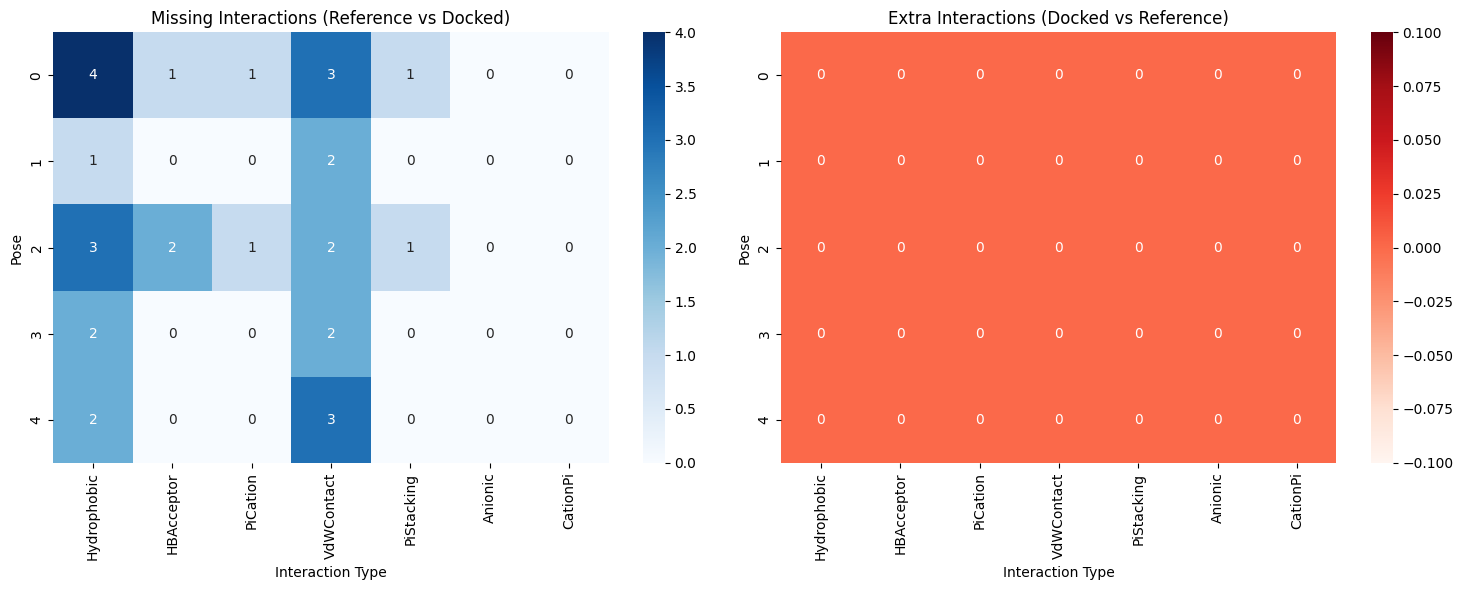

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(missing_df, cmap="Blues", annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Missing Interactions (Reference vs Docked)")
axes[0].set_xlabel("Interaction Type")
axes[0].set_ylabel("Pose")

sns.heatmap(extra_df, cmap="Reds", annot=True, fmt="d", ax=axes[1])
axes[1].set_title("Extra Interactions (Docked vs Reference)")
axes[1].set_xlabel("Interaction Type")
axes[1].set_ylabel("Pose")

plt.tight_layout()
plt.show()

### Multiple protein together

### Prepare

## Analyze

In [19]:
def analyze_all_complexes(input_df: pd.DataFrame, methods: List[str]) -> Dict[str, Dict[str, Dict[str, pd.DataFrame]]]:
    """
    Analyzes multiple protein-ligand pairs. Assumes the input DataFrame has columns:
      - complex_id: Unique identifier for each protein-ligand pair.
      - predicted_ligand: Docked ligand SDF file path.
      - true_ligand: Reference (true) ligand SDF file path.
      - protein_pdb: Protein PDB file path.
      - method: Docking method name.
      - rank: Pose rank.

    For each unique complex, the function:
      1. Computes the reference fingerprint.
      2. Initializes a ConformationAnalyzer for the complex.
      3. For each method in the provided list, computes:
           - Overall comparison summary.
           - Detailed missing/extra interaction counts.
           - Optionally, an interaction summary.

    Returns:
        A nested dictionary in the form:
        {
          complex_id: {
              method: {
                  "overall": overall_comparison_df,
                  "detailed": (missing_df, extra_df),
                  "summary": interaction_summary_df
              },
              ...
          },
          ...
        }
    """
    results = {}

    # Group by unique complex. Here we assume 'complex_id' uniquely identifies a pair.
    for complex_id, group in input_df.groupby("protein"):
        print(f"Processing complex {complex_id} ...")
        # Get the first row to extract reference paths.
        first_row = group.iloc[0]
        ref_ligand_path = first_row["true_ligand"]
        protein_path = first_row["protein_pdb"]

        # Compute the reference fingerprint.
        ref_fp_df = compute_reference_fingerprint(ref_ligand_path, protein_path)

        # Initialize an analyzer for this complex.
        analyzer = ConformationAnalyzer(group)

        complex_results = {}
        for method in methods:
            try:
                print(f"  Analyzing method: {method}")
                analyzer.analyze_method(method)
                overall = analyzer.compare_with_reference(method, ref_fp_df)
                missing_df, extra_df = analyzer.compare_with_reference_detailed(method, ref_fp_df)
                summary = analyzer.summarize_interactions(method)

                complex_results[method] = {
                    "overall": overall,
                    "detailed": (missing_df, extra_df),
                    "summary": summary
                }
            except Exception as e:
                print(f"Error processing method {method} for complex {complex_id}: {e}")
        results[complex_id] = complex_results
    return results


In [ ]:
# Load your input DataFrame (this CSV should contain columns including:
# "complex_id", "predicted_ligand", "true_ligand", "protein_pdb", "method", and "rank")

surfdock_comp_icm = ['7OZC_G6S', '7F8T_FAD', '7XFA_D9J', '6XM9_V55', '6Z0R_Q4H', '7WUY_76N', '6YR2_T1C', '7MMH_ZJY', '6M2B_EZO', '7LOE_Y84', '7UXS_OJC', '7MWU_ZPM', '6YJA_2BA', '6TW5_9M2', '7MGY_ZD1', '7OLI_8HG', '6ZPB_3D1', '7TUO_KL9', '7F5D_EUO', '6T88_MWQ', '7RWS_4UR', '7YZU_DO7']
icm_comp_surfdock = ['8B8H_OJQ', '8D19_GSH', '7QE4_NGA', '8HFN_XGC', '7WUX_6OI', '7RNI_60I', '7XBV_APC', '7PT3_3KK', ] # '6ZAE_ACV', '7R3D_APR'
# icm_comp_surfdock = ['8B8H_OJQ'] 

input_df = df[df['protein'].isin(icm_comp_surfdock)]

# Specify which docking methods you want to analyze (should match the "method" column values)
methods_to_analyze = ["icm", "surfdock"]

all_results = analyze_all_complexes(input_df, methods_to_analyze)

# Print or save the results. For example, print overall comparisons for each complex:
for complex_id, complex_data in all_results.items():
    print(f"\nComplex {complex_id}:")
    for method, result_dict in complex_data.items():
        print(f"  Method: {method}")
        print(result_dict["overall"])

Processing complex 7PT3_3KK ...


  0%|          | 0/1 [00:00<?, ?it/s]

  Analyzing method: icm


  0%|          | 0/5 [00:00<?, ?it/s]

  Analyzing method: surfdock


  0%|          | 0/5 [00:00<?, ?it/s]

Processing complex 7QE4_NGA ...


  0%|          | 0/1 [00:00<?, ?it/s]

  Analyzing method: icm


  0%|          | 0/5 [00:00<?, ?it/s]

  Analyzing method: surfdock


  0%|          | 0/5 [00:00<?, ?it/s]

Processing complex 7RNI_60I ...


  0%|          | 0/1 [00:00<?, ?it/s]

  Analyzing method: icm


  0%|          | 0/5 [00:00<?, ?it/s]

  Analyzing method: surfdock


  0%|          | 0/5 [00:00<?, ?it/s]

Processing complex 7WUX_6OI ...


  0%|          | 0/1 [00:00<?, ?it/s]

  Analyzing method: icm


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/multiprocess/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/multiprocess/pool.py", line 729, in _terminate_pool
    p.join()
  File "/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/multiprocess/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/multiprocess/popen_fork.py", line 47, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packag

  Analyzing method: surfdock


  0%|          | 0/5 [00:00<?, ?it/s]

Processing complex 7XBV_APC ...


  0%|          | 0/1 [00:00<?, ?it/s]

  Analyzing method: icm


  0%|          | 0/5 [00:00<?, ?it/s]

  Analyzing method: surfdock


  0%|          | 0/5 [00:00<?, ?it/s]

Processing complex 8B8H_OJQ ...


  0%|          | 0/1 [00:00<?, ?it/s]

  Analyzing method: icm


  0%|          | 0/5 [00:00<?, ?it/s]

  Analyzing method: surfdock


  0%|          | 0/5 [00:00<?, ?it/s]

Processing complex 8D19_GSH ...


  0%|          | 0/1 [00:00<?, ?it/s]

  Analyzing method: icm


  0%|          | 0/5 [00:00<?, ?it/s]

  Analyzing method: surfdock


  0%|          | 0/5 [00:00<?, ?it/s]

Processing complex 8HFN_XGC ...


  0%|          | 0/1 [00:00<?, ?it/s]

  Analyzing method: icm


  0%|          | 0/5 [00:00<?, ?it/s]

  Analyzing method: surfdock


  0%|          | 0/5 [00:00<?, ?it/s]


Complex 7PT3_3KK:
  Method: icm
   pose  num_missing  num_extra  num_common  total_in_ref  total_in_pose
0     0            7          0          12            27             27
1     1           10          0           9            27             33
2     2           11          0           8            27             31
3     3            6          0          13            27             29
4     4            9          0          10            27             28
  Method: surfdock
   pose  num_missing  num_extra  num_common  total_in_ref  total_in_pose
0     0            6          0          17            27             27
1     1            7          0          16            27             24
2     2            5          0          18            27             27
3     3            7          0          16            27             24
4     4            6          0          17            27             25

Complex 7QE4_NGA:
  Method: icm
   pose  num_missing  num_extra  num_co

In [ ]:
import pickle

with open("all_results.pkl", "wb") as f:
    pickle.dump(all_results, f)

### summary report 

In [20]:
def aggregate_detailed_results(all_results: dict, detail: str = "missing") -> pd.DataFrame:
    """
    Aggregates detailed interaction counts (missing or extra) across all complexes for each method.
    
    Parameters:
      all_results: Nested dictionary from analyze_all_complexes, of the form:
        {
          complex_id: {
              method: {
                  "detailed": (missing_df, extra_df),
                  ...
              },
              ...
          },
          ...
        }
      detail: "missing" or "extra" to indicate which detail to aggregate.
      
    Returns:
      A DataFrame where rows are interaction types and columns are methods. The values
      are the average (across complexes) of the average counts (across poses) for each interaction type.
    """
    # Dictionary to accumulate results per method.
    method_dict = {}
    for complex_id, complex_data in all_results.items():
        for method, result_dict in complex_data.items():
            # result_dict["detailed"] returns a tuple: (missing_df, extra_df)
            if detail == "missing":
                df_detail = result_dict["detailed"][0]
            elif detail == "extra":
                df_detail = result_dict["detailed"][1]
            else:
                raise ValueError("detail must be either 'missing' or 'extra'")
            
            # For this complex and method, average over poses (rows).
            avg_detail = df_detail.mean(axis=0)  # Series: index=interaction types, value = average count
            if method not in method_dict:
                method_dict[method] = []
            method_dict[method].append(avg_detail)
    
    # Now aggregate for each method over complexes by averaging the Series.
    method_summary = {}
    for method, series_list in method_dict.items():
        # Concatenate all Series into a DataFrame and average over columns.
        combined = pd.concat(series_list, axis=1)
        method_summary[method] = combined.mean(axis=1)
    
    # Create a summary DataFrame: rows are interaction types, columns are methods.
    summary_df = pd.DataFrame(method_summary)
    return summary_df

def plot_detailed_heatmap(summary_df: pd.DataFrame, title: str):
    """
    Plots a heatmap of the aggregated detailed interaction counts.
    
    Parameters:
      summary_df: DataFrame with rows as interaction types and columns as methods.
      title: Title for the plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(summary_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(title)
    plt.xlabel("Method")
    plt.ylabel("Interaction Type")
    plt.tight_layout()
    plt.show()

def plot_detailed_bar(summary_df: pd.DataFrame, title: str):
    """
    Plots a grouped bar chart for the aggregated detailed interaction counts.
    
    Parameters:
      summary_df: DataFrame with rows as interaction types and columns as methods.
      title: Title for the plot.
    """
    summary_df = summary_df.reset_index().melt(id_vars="index", var_name="Method", value_name="Average Count")
    plt.figure(figsize=(12, 6))
    sns.barplot(data=summary_df, x="index", y="Average Count", hue="Method")
    plt.title(title)
    plt.xlabel("Interaction Type")
    plt.ylabel("Average Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def generate_summary_report(all_results: dict) -> dict:
    """
    Generates an overall summary report that includes both overall and detailed analyses.
    
    Returns a dictionary containing:
      - overall_df: A DataFrame aggregating overall comparison metrics (from aggregate_overall_results).
      - detailed_missing_df: A DataFrame summarizing detailed missing interactions (average per interaction type by method).
      - detailed_extra_df: A DataFrame summarizing detailed extra interactions.
    """
    overall_df = aggregate_overall_overall(all_results)  # We'll assume you have a function for overall aggregation.
    detailed_missing_df = aggregate_detailed_results(all_results, detail="missing")
    detailed_extra_df = aggregate_detailed_results(all_results, detail="extra")
    
    report = {
        "overall": overall_df,
        "detailed_missing": detailed_missing_df,
        "detailed_extra": detailed_extra_df,
    }
    return report

# If you already have the overall aggregation from before:
def aggregate_overall_overall(all_results: dict) -> pd.DataFrame:
    """
    Aggregates overall metrics across complexes and methods.
    Returns a DataFrame with overall averages for each complex-method pair,
    then aggregated by method.
    """
    rows = []
    for complex_id, methods_dict in all_results.items():
        for method, result_dict in methods_dict.items():
            overall_df = result_dict["overall"]
            avg_missing = overall_df['num_missing'].mean()
            avg_extra = overall_df['num_extra'].mean()
            avg_common = overall_df['num_common'].mean()
            avg_total_in_pose = overall_df['total_in_pose'].mean()
            total_in_ref = overall_df['total_in_ref'].iloc[0]
            rows.append({
                "complex_id": complex_id,
                "method": method,
                "avg_num_missing": avg_missing,
                "avg_num_extra": avg_extra,
                "avg_num_common": avg_common,
                "total_in_ref": total_in_ref,
                "avg_total_in_pose": avg_total_in_pose
            })
    agg_df = pd.DataFrame(rows)
    # Now aggregate across complexes by method:
    method_summary = agg_df.groupby("method").mean().reset_index()
    return method_summary

def plot_summary_report(report: dict):
    """
    Generates plots for the overall and detailed summary reports.
    """
    overall_df = report["overall"]
    detailed_missing_df = report["detailed_missing"]
    detailed_extra_df = report["detailed_extra"]
    
    # Plot overall metrics (bar charts)
    plt.figure(figsize=(12, 4))
    sns.barplot(data=overall_df, x="method", y="avg_num_missing")
    plt.title("Average Missing Interactions (Overall)")
    plt.ylabel("Average Missing Count")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    sns.barplot(data=overall_df, x="method", y="avg_num_extra")
    plt.title("Average Extra Interactions (Overall)")
    plt.ylabel("Average Extra Count")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()
    
    # Plot detailed interactions as heatmaps:
    plot_detailed_heatmap(detailed_missing_df, "Detailed Missing Interactions (Average per Interaction Type)")
    plot_detailed_heatmap(detailed_extra_df, "Detailed Extra Interactions (Average per Interaction Type)")
    
    # Optionally, you can also use bar charts:
    plot_detailed_bar(detailed_missing_df, "Detailed Missing Interactions (Average per Interaction Type)")
    plot_detailed_bar(detailed_extra_df, "Detailed Extra Interactions (Average per Interaction Type)")

In [ ]:
# Generate a summary report DataFrame.
summary_report = generate_summary_report(all_results)
print(summary_report["overall"])
# Plot summary reports.
plot_summary_report(all_results)

#### what's in the retuls

In [ ]:
all_results.keys()

dict_keys(['7PT3_3KK', '7QE4_NGA', '7RNI_60I', '7WUX_6OI', '7XBV_APC', '8B8H_OJQ', '8D19_GSH', '8HFN_XGC'])

In [ ]:
all_results['8B8H_OJQ'].keys()

dict_keys(['icm', 'surfdock'])

In [ ]:
all_results['8B8H_OJQ']['icm'].keys()

dict_keys(['overall', 'detailed', 'summary'])

In [ ]:
all_results['8B8H_OJQ']['icm']['overall']

,pose,num_missing,num_extra,num_common,total_in_ref,total_in_pose
0,0,10,0,7,26,17
1,1,3,0,14,26,26
2,2,9,0,8,26,24
3,3,4,0,13,26,26
4,4,5,0,12,26,26


In [ ]:
all_results['8B8H_OJQ']['icm']['detailed']

(interaction  Hydrophobic  HBAcceptor  PiCation  VdWContact  PiStacking  \
 Pose                                                                     
 0                      4           1         1           3           1   
 1                      1           0         0           2           0   
 2                      3           2         1           2           1   
 3                      2           0         0           2           0   
 4                      2           0         0           3           0   
 
 interaction  Anionic  CationPi  
 Pose                            
 0                  0         0  
 1                  0         0  
 2                  0         0  
 3                  0         0  
 4                  0         0  ,
 interaction  Hydrophobic  HBAcceptor  PiCation  VdWContact  PiStacking  \
 Pose                                                                     
 0                      0           0         0           0           0   
 1       

In [ ]:
all_results['8B8H_OJQ']['icm']['summary']

occurrence_rate  always_present  never_present  \
ligand protein  interaction                                                   
UNL1   VAL42.A  Hydrophobic              0.2           False          False   
       LYS44.A  Hydrophobic              0.2           False          False   
                HBAcceptor               0.2           False          False   
                PiCation                 0.6           False          False   
                VdWContact               0.2           False          False   
       TYR48.A  VdWContact               0.2           False          False   
       TRP90.A  Hydrophobic              0.6           False          False   
                PiStacking               0.2           False          False   
                VdWContact               0.4           False          False   
       LYS135.A HBAcceptor               0.6           False          False   
                Anionic                  0.6           False          False   
                VdWContact               0.6           False          False   
       ASN143.A HBAcceptor               0.2           False          False   
                VdWContact               0.4           False          False   
       MET172.A Hydrophobic              0.6           False          False   
                VdWContact               0.2           False          False   
       HIS174.A Hydrophobic              0.8           False          False   
                HBAcceptor               0.4           False          False   
                CationPi                 0.2           False          False   
                PiCation                 0.6           False          False   
                PiStacking               0.6           False          False   
                VdWContact               0.8           False          False   
       ALA178.A VdWContact               0.2           False          False   
       ASP179.A Hydrophobic              0.2           False          False   
                HBAcceptor               0.2           False          False   
                VdWContact               0.2           False          False   
       ASN214.A HBAcceptor               0.2           False          False   
                VdWContact               0.4           False          False   
       SER216.A HBAcceptor               0.2           False          False   
                VdWContact               0.2           False          False   
       ARG230.A HBAcceptor               0.6           False          False   
                VdWContact               0.6           False          False   
       ILE364.A Hydrophobic              0.4           False          False   
       TYR366.A Hydrophobic              0.4           False          False   
                CationPi                 0.2           False          False   
                VdWContact               0.4           False          False   
       TYR273.B Hydrophobic              1.0            True          False   
                CationPi                 0.2           False          False   
                PiStacking               0.8           False          False   
                VdWContact               0.8           False          False   
       TYR292.B Hydrophobic              0.4           False          False   
                HBAcceptor               0.4           False          False   
                VdWContact               0.4           False          False   
       ARG298.B HBAcceptor               0.2           False          False   
                VdWContact               0.2           False          False   
       ILE319.B VdWContact               0.2           False          False   
       CYS320.B Hydrophobic              0.8           False          False   
                VdWContact               0.8           False          False   
       MET321.B Hydrophobic              0.8           False          False   


In [ ]:
# For each approach (e.g., "icm" and "surfdock"), select the conformation (per protein)
# with the lowest RMSD. We assume that the dataframe `df` contains an "rmsd" column.

methods = ["icm", "surfdock"]
selected_dfs = {}

for method in methods:
    method_df = df[df["method"] == method]
    
    # Group by protein and select the row with minimal RMSD for each protein.
    best_indices = method_df.groupby("protein")["rmsd"].idxmin()
    best_df = method_df.loc[best_indices].reset_index(drop=True)
    selected_dfs[method] = best_df
    
    print(f"Selected best conformations for method: {method}")
    display(best_df)

## failure and success

In [21]:
methods = ["icm", "surfdock"]

selected_dfs = {}

for method in methods:
    method_df = df[df["method"] == method]
    
    # Group by protein and select the row with minimal RMSD for each protein.
    best_indices = method_df.groupby("protein")["rmsd"].idxmin()
    best_df = method_df.loc[best_indices].reset_index(drop=True)
    selected_dfs[method] = best_df
    
    print(f"Selected best conformations for method: {method}")
    # display(best_df)
    
    for split in ["success", "failure"]:
      input_df = best_df[best_df["rmsd_≤_2å"]] if split == "success" else best_df[~best_df["rmsd_≤_2å"]]

      all_results = analyze_all_complexes(input_df, method)

      # Print or save the results. For example, print overall comparisons for each complex:
      for complex_id, complex_data in all_results.items():
          print(f"\nComplex {complex_id}:")
          for method, result_dict in complex_data.items():
              print(f"  Method: {method}")
              print(result_dict["overall"])
      
      with open(os.path.join(BASE_DIR, f"PoseBench/notebooks/{method}_{split}.pkl"), "wb") as f:
        pickle.dump(all_results, f)

Selected best conformations for method: icm
Processing complex 5SAK_ZRY ...


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 